In [1]:
### A Pluto.jl notebook ###
# v0.19.46

using Markdown
using InteractiveUtils

In [1]:
using DelimitedFiles, Random, Statistics, Plots,LinearAlgebra, Dates

In [3]:
begin
	train_data = readdlm("20news-bydate/matlab/train.data", Int64)
	test_data = readdlm("20news-bydate/matlab/test.data", Int64)
	println(size(train_data))
	println(size(test_data))

	train_label = readdlm("20news-bydate/matlab/train.label", Int64)
	test_label = readdlm("20news-bydate/matlab/test.label", Int64)

	println(size(train_label))
	println(size(test_label))
end

(1467345, 3)
(967874, 3)
(11269, 1)
(7505, 1)


In [4]:
begin
    num_samples = maximum(train_data[:, 1])
    num_test_samples = maximum(test_data[:, 1])

    unique_vocab = unique(vcat(train_data[:, 2], test_data[:, 2], ))
    vocab_size = length(unique_vocab)

    train_X = zeros(Int64, num_samples, vocab_size)
    test_X = zeros(Int64, num_test_samples, vocab_size)

    for row in eachrow(train_data)
        train_X[row[1], row[2]] = row[3]
    end

    for row in eachrow(test_data)
        test_X[row[1], row[2]] = row[3]
    end
end


In [6]:
println(size(test_X))

(7505, 61188)


In [5]:
begin
	
	lambdas = [10.0, 1.0, 0.1, 0.01]
	# num_iters = 1_000_000
	# log_interval = 1000
	num_iters = 10000
	log_interval = 100
	
	k = maximum(train_label)  # number of classes
	m = size(train_X, 2)       # number of features
	num_train = size(train_X, 1)
	num_test = size(test_X, 1)
	
	function predict(X, Θ)
    scores = X * Θ           # size (n_samples, k) — matrix-matrix multiplication
	    return map(argmax, eachrow(scores))  # get class with max score for each sample
	end

	
	function accuracy(y_pred, y_true)
	    return mean(y_pred .== y_true)
	end

	println("SETUP DONE")
end
	

SETUP DONE


In [7]:
begin
    results = Dict()

    for λ in lambdas
        println("\n==== Running for λ = $λ ====")
        Θ = rand(m, k)
        acc_log = Float64[]

        grad = zeros(m, k)
        Θ_half = similar(Θ)

        iter_times = Float64[]
        grad_times = Float64[]
        prox_times = Float64[]
        test_times = Float64[]

        for t in 1:num_iters
            iter_start = time()
            γ = 1.0 / t

            i = rand(1:num_train)
            x = view(train_X, i, :)
            y = train_label[i]

            ## === Gradient computation ===
            grad_start = time()

            xθ = Θ' * x
            xθ[y] -= 1.0
            c_star = findmax(xθ)[2]

            fill!(grad, 0.0)
            @views grad[:, c_star] .+= x
            @views grad[:, y]      .-= x
            @. Θ_half = Θ - γ * grad

            push!(grad_times, time() - grad_start)

            ## === Proximal update ===
            prox_start = time()

            Threads.@threads for j in 1:m
                θj = @view Θ_half[j, :]
                norm_θj = norm(θj)
                if norm_θj > 0
                    shrink = max(0.0, 1.0 - γ * λ / norm_θj)
                    @. Θ[j, :] = shrink * θj
                else
                    @. Θ[j, :] = 0.0
                end
            end

            push!(prox_times, time() - prox_start)

            ## === Evaluation ===
            test_time = 0.0
            if t % log_interval == 0
                test_start = time()
                y_pred = predict(test_X, Θ)
                acc = accuracy(y_pred, test_label)
                push!(acc_log, acc)
                test_time = time() - test_start
                push!(test_times, test_time)
            end

            push!(iter_times, time() - iter_start)

            ## === Logging ===
            if t % log_interval == 0 && t > 0
                avg_it = mean(iter_times[max(end-999, 1):end])
                avg_grad = mean(grad_times[max(end-999, 1):end])
                avg_prox = mean(prox_times[max(end-999, 1):end])
                avg_test = mean(test_times[max(end-999, 1):end])

                eta = avg_it * (num_iters - t)
                eta_str = Dates.format(now() + Dates.Second(round(Int, eta)), "HH:MM:SS")

                println("Iter $t | Acc: $(round(acc, digits=4)) | Δt Test: $(round(test_time, digits=3))s")
                println("  Avg Grad: $(round(avg_grad*1000, digits=2)) ms | Avg Prox: $(round(avg_prox*1000, digits=2)) ms | Avg Test: $(round(avg_test*1000, digits=2)) ms")
                println("  Avg It/s: $(round(1/avg_it, digits=2)) | ETA: $eta_str")
            end
        end

        results[λ] = (Θ=copy(Θ), acc_log=acc_log)
    end
end


==== Running for λ = 10.0 ====
Iter 100 | Acc: 0.0529 | Δt Test: 0.478s
  Avg Grad: 15.02 ms | Avg Prox: 9.74 ms | Avg Test: 478.48 ms
  Avg It/s: 33.55 | ETA: 18:43:05
Iter 200 | Acc: 0.0424 | Δt Test: 0.002s
  Avg Grad: 9.7 ms | Avg Prox: 8.56 ms | Avg Test: 240.01 ms
  Avg It/s: 48.07 | ETA: 18:41:35
Iter 300 | Acc: 0.049 | Δt Test: 0.002s
  Avg Grad: 7.91 ms | Avg Prox: 8.09 ms | Avg Test: 160.57 ms
  Avg It/s: 56.49 | ETA: 18:41:04
Iter 400 | Acc: 0.0508 | Δt Test: 0.001s
  Avg Grad: 8.56 ms | Avg Prox: 7.84 ms | Avg Test: 120.77 ms
  Avg It/s: 56.56 | ETA: 18:41:04
Iter 500 | Acc: 0.042 | Δt Test: 0.001s
  Avg Grad: 8.6 ms | Avg Prox: 7.71 ms | Avg Test: 96.91 ms
  Avg It/s: 57.67 | ETA: 18:41:01
Iter 600 | Acc: 0.0469 | Δt Test: 0.001s
  Avg Grad: 8.24 ms | Avg Prox: 7.63 ms | Avg Test: 80.99 ms
  Avg It/s: 59.75 | ETA: 18:40:54
Iter 700 | Acc: 0.0524 | Δt Test: 0.005s
  Avg Grad: 7.79 ms | Avg Prox: 7.59 ms | Avg Test: 70.18 ms
  Avg It/s: 62.0 | ETA: 18:40:48
Iter 800 | Acc: 

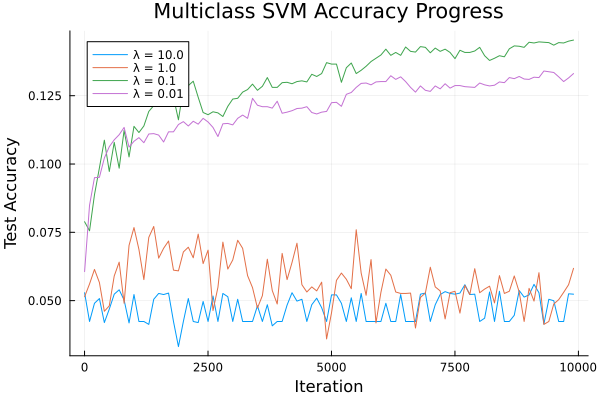

In [8]:
begin
		# --- Plot Accuracy Progress ---
	plot()
	for λ in lambdas
	    plot!(1:log_interval:num_iters, results[λ][:acc_log], label="λ = $λ")
	end
	xlabel!("Iteration")
	ylabel!("Test Accuracy")
	title!("Multiclass SVM Accuracy Progress")
end

In [9]:
begin
	vocab = readlines("data/vocabulary.txt")
	zero_words = Dict()

	for λ in lambdas
	    Θ = results[λ][:Θ]
	    
	    # Find indices of features (words) with all-zero weights across classes
	    zero_idx = findall(row -> all(row .== 0.0), eachrow(Θ))
	    
	    # Map indices to words
	    words = vocab[zero_idx]
	    zero_words[λ] = words
	    
	    println("λ = $λ → $(length(words)) words with zero coefficients")
	    println("Sample zeroed words: ", words[1:min(end, 10)])
	end
end


λ = 10.0 → 61181 words with zero coefficients
Sample zeroed words: ["archive", "name", "atheism", "resources", "alt", "last", "modified", "december", "version", "atheist"]
λ = 1.0 → 60995 words with zero coefficients
Sample zeroed words: ["archive", "name", "atheism", "resources", "alt", "last", "modified", "december", "version", "atheist"]
λ = 0.1 → 0 words with zero coefficients
Sample zeroed words: String[]
λ = 0.01 → 0 words with zero coefficients
Sample zeroed words: String[]


In [ ]:
PLUTO_PROJECT_TOML_CONTENTS = """
[deps]
Dates = "ade2ca70-3891-5945-98fb-dc099432e06a"
DelimitedFiles = "8bb1440f-4735-579b-a4ab-409b98df4dab"
LinearAlgebra = "37e2e46d-f89d-539d-b4ee-838fcccc9c8e"
Plots = "91a5bcdd-55d7-5caf-9e0b-520d859cae80"
Random = "9a3f8284-a2c9-5f02-9a11-845980a1fd5c"
Statistics = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"

[compat]
DelimitedFiles = "~1.9.1"
Plots = "~1.40.8"
"""

In [ ]:
PLUTO_MANIFEST_TOML_CONTENTS = """
# This file is machine-generated - editing it directly is not advised

julia_version = "1.10.4"
manifest_format = "2.0"
project_hash = "cb589ecea781e42de2e4b455e60158426950857b"

[[deps.AliasTables]]
deps = ["PtrArrays", "Random"]
git-tree-sha1 = "9876e1e164b144ca45e9e3198d0b689cadfed9ff"
uuid = "66dad0bd-aa9a-41b7-9441-69ab47430ed8"
version = "1.1.3"

[[deps.ArgTools]]
uuid = "0dad84c5-d112-42e6-8d28-ef12dabb789f"
version = "1.1.1"

[[deps.Artifacts]]
uuid = "56f22d72-fd6d-98f1-02f0-08ddc0907c33"

[[deps.Base64]]
uuid = "2a0f44e3-6c83-55bd-87e4-b1978d98bd5f"

[[deps.BitFlags]]
git-tree-sha1 = "0691e34b3bb8be9307330f88d1a3c3f25466c24d"
uuid = "d1d4a3ce-64b1-5f1a-9ba4-7e7e69966f35"
version = "0.1.9"

[[deps.Bzip2_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "9e2a6b69137e6969bab0152632dcb3bc108c8bdd"
uuid = "6e34b625-4abd-537c-b88f-471c36dfa7a0"
version = "1.0.8+1"

[[deps.Cairo_jll]]
deps = ["Artifacts", "Bzip2_jll", "CompilerSupportLibraries_jll", "Fontconfig_jll", "FreeType2_jll", "Glib_jll", "JLLWrappers", "LZO_jll", "Libdl", "Pixman_jll", "Xorg_libXext_jll", "Xorg_libXrender_jll", "Zlib_jll", "libpng_jll"]
git-tree-sha1 = "009060c9a6168704143100f36ab08f06c2af4642"
uuid = "83423d85-b0ee-5818-9007-b63ccbeb887a"
version = "1.18.2+1"

[[deps.CodecZlib]]
deps = ["TranscodingStreams", "Zlib_jll"]
git-tree-sha1 = "bce6804e5e6044c6daab27bb533d1295e4a2e759"
uuid = "944b1d66-785c-5afd-91f1-9de20f533193"
version = "0.7.6"

[[deps.ColorSchemes]]
deps = ["ColorTypes", "ColorVectorSpace", "Colors", "FixedPointNumbers", "PrecompileTools", "Random"]
git-tree-sha1 = "b5278586822443594ff615963b0c09755771b3e0"
uuid = "35d6a980-a343-548e-a6ea-1d62b119f2f4"
version = "3.26.0"

[[deps.ColorTypes]]
deps = ["FixedPointNumbers", "Random"]
git-tree-sha1 = "b10d0b65641d57b8b4d5e234446582de5047050d"
uuid = "3da002f7-5984-5a60-b8a6-cbb66c0b333f"
version = "0.11.5"

[[deps.ColorVectorSpace]]
deps = ["ColorTypes", "FixedPointNumbers", "LinearAlgebra", "Requires", "Statistics", "TensorCore"]
git-tree-sha1 = "a1f44953f2382ebb937d60dafbe2deea4bd23249"
uuid = "c3611d14-8923-5661-9e6a-0046d554d3a4"
version = "0.10.0"

    [deps.ColorVectorSpace.extensions]
    SpecialFunctionsExt = "SpecialFunctions"

    [deps.ColorVectorSpace.weakdeps]
    SpecialFunctions = "276daf66-3868-5448-9aa4-cd146d93841b"

[[deps.Colors]]
deps = ["ColorTypes", "FixedPointNumbers", "Reexport"]
git-tree-sha1 = "362a287c3aa50601b0bc359053d5c2468f0e7ce0"
uuid = "5ae59095-9a9b-59fe-a467-6f913c188581"
version = "0.12.11"

[[deps.Compat]]
deps = ["TOML", "UUIDs"]
git-tree-sha1 = "8ae8d32e09f0dcf42a36b90d4e17f5dd2e4c4215"
uuid = "34da2185-b29b-5c13-b0c7-acf172513d20"
version = "4.16.0"
weakdeps = ["Dates", "LinearAlgebra"]

    [deps.Compat.extensions]
    CompatLinearAlgebraExt = "LinearAlgebra"

[[deps.CompilerSupportLibraries_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "e66e0078-7015-5450-92f7-15fbd957f2ae"
version = "1.1.1+0"

[[deps.ConcurrentUtilities]]
deps = ["Serialization", "Sockets"]
git-tree-sha1 = "ea32b83ca4fefa1768dc84e504cc0a94fb1ab8d1"
uuid = "f0e56b4a-5159-44fe-b623-3e5288b988bb"
version = "2.4.2"

[[deps.Contour]]
git-tree-sha1 = "439e35b0b36e2e5881738abc8857bd92ad6ff9a8"
uuid = "d38c429a-6771-53c6-b99e-75d170b6e991"
version = "0.6.3"

[[deps.DataAPI]]
git-tree-sha1 = "abe83f3a2f1b857aac70ef8b269080af17764bbe"
uuid = "9a962f9c-6df0-11e9-0e5d-c546b8b5ee8a"
version = "1.16.0"

[[deps.DataStructures]]
deps = ["Compat", "InteractiveUtils", "OrderedCollections"]
git-tree-sha1 = "1d0a14036acb104d9e89698bd408f63ab58cdc82"
uuid = "864edb3b-99cc-5e75-8d2d-829cb0a9cfe8"
version = "0.18.20"

[[deps.Dates]]
deps = ["Printf"]
uuid = "ade2ca70-3891-5945-98fb-dc099432e06a"

[[deps.Dbus_jll]]
deps = ["Artifacts", "Expat_jll", "JLLWrappers", "Libdl"]
git-tree-sha1 = "fc173b380865f70627d7dd1190dc2fce6cc105af"
uuid = "ee1fde0b-3d02-5ea6-8484-8dfef6360eab"
version = "1.14.10+0"

[[deps.DelimitedFiles]]
deps = ["Mmap"]
git-tree-sha1 = "9e2f36d3c96a820c678f2f1f1782582fcf685bae"
uuid = "8bb1440f-4735-579b-a4ab-409b98df4dab"
version = "1.9.1"

[[deps.DocStringExtensions]]
deps = ["LibGit2"]
git-tree-sha1 = "2fb1e02f2b635d0845df5d7c167fec4dd739b00d"
uuid = "ffbed154-4ef7-542d-bbb7-c09d3a79fcae"
version = "0.9.3"

[[deps.Downloads]]
deps = ["ArgTools", "FileWatching", "LibCURL", "NetworkOptions"]
uuid = "f43a241f-c20a-4ad4-852c-f6b1247861c6"
version = "1.6.0"

[[deps.EpollShim_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "8e9441ee83492030ace98f9789a654a6d0b1f643"
uuid = "2702e6a9-849d-5ed8-8c21-79e8b8f9ee43"
version = "0.0.20230411+0"

[[deps.ExceptionUnwrapping]]
deps = ["Test"]
git-tree-sha1 = "dcb08a0d93ec0b1cdc4af184b26b591e9695423a"
uuid = "460bff9d-24e4-43bc-9d9f-a8973cb893f4"
version = "0.1.10"

[[deps.Expat_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "1c6317308b9dc757616f0b5cb379db10494443a7"
uuid = "2e619515-83b5-522b-bb60-26c02a35a201"
version = "2.6.2+0"

[[deps.FFMPEG]]
deps = ["FFMPEG_jll"]
git-tree-sha1 = "53ebe7511fa11d33bec688a9178fac4e49eeee00"
uuid = "c87230d0-a227-11e9-1b43-d7ebe4e7570a"
version = "0.4.2"

[[deps.FFMPEG_jll]]
deps = ["Artifacts", "Bzip2_jll", "FreeType2_jll", "FriBidi_jll", "JLLWrappers", "LAME_jll", "Libdl", "Ogg_jll", "OpenSSL_jll", "Opus_jll", "PCRE2_jll", "Zlib_jll", "libaom_jll", "libass_jll", "libfdk_aac_jll", "libvorbis_jll", "x264_jll", "x265_jll"]
git-tree-sha1 = "466d45dc38e15794ec7d5d63ec03d776a9aff36e"
uuid = "b22a6f82-2f65-5046-a5b2-351ab43fb4e5"
version = "4.4.4+1"

[[deps.FileWatching]]
uuid = "7b1f6079-737a-58dc-b8bc-7a2ca5c1b5ee"

[[deps.FixedPointNumbers]]
deps = ["Statistics"]
git-tree-sha1 = "05882d6995ae5c12bb5f36dd2ed3f61c98cbb172"
uuid = "53c48c17-4a7d-5ca2-90c5-79b7896eea93"
version = "0.8.5"

[[deps.Fontconfig_jll]]
deps = ["Artifacts", "Bzip2_jll", "Expat_jll", "FreeType2_jll", "JLLWrappers", "Libdl", "Libuuid_jll", "Zlib_jll"]
git-tree-sha1 = "db16beca600632c95fc8aca29890d83788dd8b23"
uuid = "a3f928ae-7b40-5064-980b-68af3947d34b"
version = "2.13.96+0"

[[deps.Format]]
git-tree-sha1 = "9c68794ef81b08086aeb32eeaf33531668d5f5fc"
uuid = "1fa38f19-a742-5d3f-a2b9-30dd87b9d5f8"
version = "1.3.7"

[[deps.FreeType2_jll]]
deps = ["Artifacts", "Bzip2_jll", "JLLWrappers", "Libdl", "Zlib_jll"]
git-tree-sha1 = "5c1d8ae0efc6c2e7b1fc502cbe25def8f661b7bc"
uuid = "d7e528f0-a631-5988-bf34-fe36492bcfd7"
version = "2.13.2+0"

[[deps.FriBidi_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "1ed150b39aebcc805c26b93a8d0122c940f64ce2"
uuid = "559328eb-81f9-559d-9380-de523a88c83c"
version = "1.0.14+0"

[[deps.GLFW_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libglvnd_jll", "Xorg_libXcursor_jll", "Xorg_libXi_jll", "Xorg_libXinerama_jll", "Xorg_libXrandr_jll", "libdecor_jll", "xkbcommon_jll"]
git-tree-sha1 = "532f9126ad901533af1d4f5c198867227a7bb077"
uuid = "0656b61e-2033-5cc2-a64a-77c0f6c09b89"
version = "3.4.0+1"

[[deps.GR]]
deps = ["Artifacts", "Base64", "DelimitedFiles", "Downloads", "GR_jll", "HTTP", "JSON", "Libdl", "LinearAlgebra", "Preferences", "Printf", "Qt6Wayland_jll", "Random", "Serialization", "Sockets", "TOML", "Tar", "Test", "p7zip_jll"]
git-tree-sha1 = "629693584cef594c3f6f99e76e7a7ad17e60e8d5"
uuid = "28b8d3ca-fb5f-59d9-8090-bfdbd6d07a71"
version = "0.73.7"

[[deps.GR_jll]]
deps = ["Artifacts", "Bzip2_jll", "Cairo_jll", "FFMPEG_jll", "Fontconfig_jll", "FreeType2_jll", "GLFW_jll", "JLLWrappers", "JpegTurbo_jll", "Libdl", "Libtiff_jll", "Pixman_jll", "Qt6Base_jll", "Zlib_jll", "libpng_jll"]
git-tree-sha1 = "a8863b69c2a0859f2c2c87ebdc4c6712e88bdf0d"
uuid = "d2c73de3-f751-5644-a686-071e5b155ba9"
version = "0.73.7+0"

[[deps.Gettext_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "JLLWrappers", "Libdl", "Libiconv_jll", "Pkg", "XML2_jll"]
git-tree-sha1 = "9b02998aba7bf074d14de89f9d37ca24a1a0b046"
uuid = "78b55507-aeef-58d4-861c-77aaff3498b1"
version = "0.21.0+0"

[[deps.Glib_jll]]
deps = ["Artifacts", "Gettext_jll", "JLLWrappers", "Libdl", "Libffi_jll", "Libiconv_jll", "Libmount_jll", "PCRE2_jll", "Zlib_jll"]
git-tree-sha1 = "674ff0db93fffcd11a3573986e550d66cd4fd71f"
uuid = "7746bdde-850d-59dc-9ae8-88ece973131d"
version = "2.80.5+0"

[[deps.Graphite2_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "344bf40dcab1073aca04aa0df4fb092f920e4011"
uuid = "3b182d85-2403-5c21-9c21-1e1f0cc25472"
version = "1.3.14+0"

[[deps.Grisu]]
git-tree-sha1 = "53bb909d1151e57e2484c3d1b53e19552b887fb2"
uuid = "42e2da0e-8278-4e71-bc24-59509adca0fe"
version = "1.0.2"

[[deps.HTTP]]
deps = ["Base64", "CodecZlib", "ConcurrentUtilities", "Dates", "ExceptionUnwrapping", "Logging", "LoggingExtras", "MbedTLS", "NetworkOptions", "OpenSSL", "Random", "SimpleBufferStream", "Sockets", "URIs", "UUIDs"]
git-tree-sha1 = "d1d712be3164d61d1fb98e7ce9bcbc6cc06b45ed"
uuid = "cd3eb016-35fb-5094-929b-558a96fad6f3"
version = "1.10.8"

[[deps.HarfBuzz_jll]]
deps = ["Artifacts", "Cairo_jll", "Fontconfig_jll", "FreeType2_jll", "Glib_jll", "Graphite2_jll", "JLLWrappers", "Libdl", "Libffi_jll"]
git-tree-sha1 = "401e4f3f30f43af2c8478fc008da50096ea5240f"
uuid = "2e76f6c2-a576-52d4-95c1-20adfe4de566"
version = "8.3.1+0"

[[deps.InteractiveUtils]]
deps = ["Markdown"]
uuid = "b77e0a4c-d291-57a0-90e8-8db25a27a240"

[[deps.IrrationalConstants]]
git-tree-sha1 = "630b497eafcc20001bba38a4651b327dcfc491d2"
uuid = "92d709cd-6900-40b7-9082-c6be49f344b6"
version = "0.2.2"

[[deps.JLFzf]]
deps = ["Pipe", "REPL", "Random", "fzf_jll"]
git-tree-sha1 = "39d64b09147620f5ffbf6b2d3255be3c901bec63"
uuid = "1019f520-868f-41f5-a6de-eb00f4b6a39c"
version = "0.1.8"

[[deps.JLLWrappers]]
deps = ["Artifacts", "Preferences"]
git-tree-sha1 = "f389674c99bfcde17dc57454011aa44d5a260a40"
uuid = "692b3bcd-3c85-4b1f-b108-f13ce0eb3210"
version = "1.6.0"

[[deps.JSON]]
deps = ["Dates", "Mmap", "Parsers", "Unicode"]
git-tree-sha1 = "31e996f0a15c7b280ba9f76636b3ff9e2ae58c9a"
uuid = "682c06a0-de6a-54ab-a142-c8b1cf79cde6"
version = "0.21.4"

[[deps.JpegTurbo_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "25ee0be4d43d0269027024d75a24c24d6c6e590c"
uuid = "aacddb02-875f-59d6-b918-886e6ef4fbf8"
version = "3.0.4+0"

[[deps.LAME_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "170b660facf5df5de098d866564877e119141cbd"
uuid = "c1c5ebd0-6772-5130-a774-d5fcae4a789d"
version = "3.100.2+0"

[[deps.LERC_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "bf36f528eec6634efc60d7ec062008f171071434"
uuid = "88015f11-f218-50d7-93a8-a6af411a945d"
version = "3.0.0+1"

[[deps.LLVMOpenMP_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "78211fb6cbc872f77cad3fc0b6cf647d923f4929"
uuid = "1d63c593-3942-5779-bab2-d838dc0a180e"
version = "18.1.7+0"

[[deps.LZO_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "854a9c268c43b77b0a27f22d7fab8d33cdb3a731"
uuid = "dd4b983a-f0e5-5f8d-a1b7-129d4a5fb1ac"
version = "2.10.2+3"

[[deps.LaTeXStrings]]
git-tree-sha1 = "50901ebc375ed41dbf8058da26f9de442febbbec"
uuid = "b964fa9f-0449-5b57-a5c2-d3ea65f4040f"
version = "1.3.1"

[[deps.Latexify]]
deps = ["Format", "InteractiveUtils", "LaTeXStrings", "MacroTools", "Markdown", "OrderedCollections", "Requires"]
git-tree-sha1 = "ce5f5621cac23a86011836badfedf664a612cee4"
uuid = "23fbe1c1-3f47-55db-b15f-69d7ec21a316"
version = "0.16.5"

    [deps.Latexify.extensions]
    DataFramesExt = "DataFrames"
    SparseArraysExt = "SparseArrays"
    SymEngineExt = "SymEngine"

    [deps.Latexify.weakdeps]
    DataFrames = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
    SparseArrays = "2f01184e-e22b-5df5-ae63-d93ebab69eaf"
    SymEngine = "123dc426-2d89-5057-bbad-38513e3affd8"

[[deps.LibCURL]]
deps = ["LibCURL_jll", "MozillaCACerts_jll"]
uuid = "b27032c2-a3e7-50c8-80cd-2d36dbcbfd21"
version = "0.6.4"

[[deps.LibCURL_jll]]
deps = ["Artifacts", "LibSSH2_jll", "Libdl", "MbedTLS_jll", "Zlib_jll", "nghttp2_jll"]
uuid = "deac9b47-8bc7-5906-a0fe-35ac56dc84c0"
version = "8.4.0+0"

[[deps.LibGit2]]
deps = ["Base64", "LibGit2_jll", "NetworkOptions", "Printf", "SHA"]
uuid = "76f85450-5226-5b5a-8eaa-529ad045b433"

[[deps.LibGit2_jll]]
deps = ["Artifacts", "LibSSH2_jll", "Libdl", "MbedTLS_jll"]
uuid = "e37daf67-58a4-590a-8e99-b0245dd2ffc5"
version = "1.6.4+0"

[[deps.LibSSH2_jll]]
deps = ["Artifacts", "Libdl", "MbedTLS_jll"]
uuid = "29816b5a-b9ab-546f-933c-edad1886dfa8"
version = "1.11.0+1"

[[deps.Libdl]]
uuid = "8f399da3-3557-5675-b5ff-fb832c97cbdb"

[[deps.Libffi_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "0b4a5d71f3e5200a7dff793393e09dfc2d874290"
uuid = "e9f186c6-92d2-5b65-8a66-fee21dc1b490"
version = "3.2.2+1"

[[deps.Libgcrypt_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libgpg_error_jll"]
git-tree-sha1 = "9fd170c4bbfd8b935fdc5f8b7aa33532c991a673"
uuid = "d4300ac3-e22c-5743-9152-c294e39db1e4"
version = "1.8.11+0"

[[deps.Libglvnd_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll", "Xorg_libXext_jll"]
git-tree-sha1 = "6f73d1dd803986947b2c750138528a999a6c7733"
uuid = "7e76a0d4-f3c7-5321-8279-8d96eeed0f29"
version = "1.6.0+0"

[[deps.Libgpg_error_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "fbb1f2bef882392312feb1ede3615ddc1e9b99ed"
uuid = "7add5ba3-2f88-524e-9cd5-f83b8a55f7b8"
version = "1.49.0+0"

[[deps.Libiconv_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "f9557a255370125b405568f9767d6d195822a175"
uuid = "94ce4f54-9a6c-5748-9c1c-f9c7231a4531"
version = "1.17.0+0"

[[deps.Libmount_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "0c4f9c4f1a50d8f35048fa0532dabbadf702f81e"
uuid = "4b2f31a3-9ecc-558c-b454-b3730dcb73e9"
version = "2.40.1+0"

[[deps.Libtiff_jll]]
deps = ["Artifacts", "JLLWrappers", "JpegTurbo_jll", "LERC_jll", "Libdl", "XZ_jll", "Zlib_jll", "Zstd_jll"]
git-tree-sha1 = "2da088d113af58221c52828a80378e16be7d037a"
uuid = "89763e89-9b03-5906-acba-b20f662cd828"
version = "4.5.1+1"

[[deps.Libuuid_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "5ee6203157c120d79034c748a2acba45b82b8807"
uuid = "38a345b3-de98-5d2b-a5d3-14cd9215e700"
version = "2.40.1+0"

[[deps.LinearAlgebra]]
deps = ["Libdl", "OpenBLAS_jll", "libblastrampoline_jll"]
uuid = "37e2e46d-f89d-539d-b4ee-838fcccc9c8e"

[[deps.LogExpFunctions]]
deps = ["DocStringExtensions", "IrrationalConstants", "LinearAlgebra"]
git-tree-sha1 = "a2d09619db4e765091ee5c6ffe8872849de0feea"
uuid = "2ab3a3ac-af41-5b50-aa03-7779005ae688"
version = "0.3.28"

    [deps.LogExpFunctions.extensions]
    LogExpFunctionsChainRulesCoreExt = "ChainRulesCore"
    LogExpFunctionsChangesOfVariablesExt = "ChangesOfVariables"
    LogExpFunctionsInverseFunctionsExt = "InverseFunctions"

    [deps.LogExpFunctions.weakdeps]
    ChainRulesCore = "d360d2e6-b24c-11e9-a2a3-2a2ae2dbcce4"
    ChangesOfVariables = "9e997f8a-9a97-42d5-a9f1-ce6bfc15e2c0"
    InverseFunctions = "3587e190-3f89-42d0-90ee-14403ec27112"

[[deps.Logging]]
uuid = "56ddb016-857b-54e1-b83d-db4d58db5568"

[[deps.LoggingExtras]]
deps = ["Dates", "Logging"]
git-tree-sha1 = "c1dd6d7978c12545b4179fb6153b9250c96b0075"
uuid = "e6f89c97-d47a-5376-807f-9c37f3926c36"
version = "1.0.3"

[[deps.MacroTools]]
deps = ["Markdown", "Random"]
git-tree-sha1 = "2fa9ee3e63fd3a4f7a9a4f4744a52f4856de82df"
uuid = "1914dd2f-81c6-5fcd-8719-6d5c9610ff09"
version = "0.5.13"

[[deps.Markdown]]
deps = ["Base64"]
uuid = "d6f4376e-aef5-505a-96c1-9c027394607a"

[[deps.MbedTLS]]
deps = ["Dates", "MbedTLS_jll", "MozillaCACerts_jll", "NetworkOptions", "Random", "Sockets"]
git-tree-sha1 = "c067a280ddc25f196b5e7df3877c6b226d390aaf"
uuid = "739be429-bea8-5141-9913-cc70e7f3736d"
version = "1.1.9"

[[deps.MbedTLS_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "c8ffd9c3-330d-5841-b78e-0817d7145fa1"
version = "2.28.2+1"

[[deps.Measures]]
git-tree-sha1 = "c13304c81eec1ed3af7fc20e75fb6b26092a1102"
uuid = "442fdcdd-2543-5da2-b0f3-8c86c306513e"
version = "0.3.2"

[[deps.Missings]]
deps = ["DataAPI"]
git-tree-sha1 = "ec4f7fbeab05d7747bdf98eb74d130a2a2ed298d"
uuid = "e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28"
version = "1.2.0"

[[deps.Mmap]]
uuid = "a63ad114-7e13-5084-954f-fe012c677804"

[[deps.MozillaCACerts_jll]]
uuid = "14a3606d-f60d-562e-9121-12d972cd8159"
version = "2023.1.10"

[[deps.NaNMath]]
deps = ["OpenLibm_jll"]
git-tree-sha1 = "0877504529a3e5c3343c6f8b4c0381e57e4387e4"
uuid = "77ba4419-2d1f-58cd-9bb1-8ffee604a2e3"
version = "1.0.2"

[[deps.NetworkOptions]]
uuid = "ca575930-c2e3-43a9-ace4-1e988b2c1908"
version = "1.2.0"

[[deps.Ogg_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "887579a3eb005446d514ab7aeac5d1d027658b8f"
uuid = "e7412a2a-1a6e-54c0-be00-318e2571c051"
version = "1.3.5+1"

[[deps.OpenBLAS_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "Libdl"]
uuid = "4536629a-c528-5b80-bd46-f80d51c5b363"
version = "0.3.23+4"

[[deps.OpenLibm_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "05823500-19ac-5b8b-9628-191a04bc5112"
version = "0.8.1+2"

[[deps.OpenSSL]]
deps = ["BitFlags", "Dates", "MozillaCACerts_jll", "OpenSSL_jll", "Sockets"]
git-tree-sha1 = "38cb508d080d21dc1128f7fb04f20387ed4c0af4"
uuid = "4d8831e6-92b7-49fb-bdf8-b643e874388c"
version = "1.4.3"

[[deps.OpenSSL_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "1b35263570443fdd9e76c76b7062116e2f374ab8"
uuid = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
version = "3.0.15+0"

[[deps.Opus_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "6703a85cb3781bd5909d48730a67205f3f31a575"
uuid = "91d4177d-7536-5919-b921-800302f37372"
version = "1.3.3+0"

[[deps.OrderedCollections]]
git-tree-sha1 = "dfdf5519f235516220579f949664f1bf44e741c5"
uuid = "bac558e1-5e72-5ebc-8fee-abe8a469f55d"
version = "1.6.3"

[[deps.PCRE2_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "efcefdf7-47ab-520b-bdef-62a2eaa19f15"
version = "10.42.0+1"

[[deps.Pango_jll]]
deps = ["Artifacts", "Cairo_jll", "Fontconfig_jll", "FreeType2_jll", "FriBidi_jll", "Glib_jll", "HarfBuzz_jll", "JLLWrappers", "Libdl"]
git-tree-sha1 = "e127b609fb9ecba6f201ba7ab753d5a605d53801"
uuid = "36c8627f-9965-5494-a995-c6b170f724f3"
version = "1.54.1+0"

[[deps.Parsers]]
deps = ["Dates", "PrecompileTools", "UUIDs"]
git-tree-sha1 = "8489905bcdbcfac64d1daa51ca07c0d8f0283821"
uuid = "69de0a69-1ddd-5017-9359-2bf0b02dc9f0"
version = "2.8.1"

[[deps.Pipe]]
git-tree-sha1 = "6842804e7867b115ca9de748a0cf6b364523c16d"
uuid = "b98c9c47-44ae-5843-9183-064241ee97a0"
version = "1.3.0"

[[deps.Pixman_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "JLLWrappers", "LLVMOpenMP_jll", "Libdl"]
git-tree-sha1 = "35621f10a7531bc8fa58f74610b1bfb70a3cfc6b"
uuid = "30392449-352a-5448-841d-b1acce4e97dc"
version = "0.43.4+0"

[[deps.Pkg]]
deps = ["Artifacts", "Dates", "Downloads", "FileWatching", "LibGit2", "Libdl", "Logging", "Markdown", "Printf", "REPL", "Random", "SHA", "Serialization", "TOML", "Tar", "UUIDs", "p7zip_jll"]
uuid = "44cfe95a-1eb2-52ea-b672-e2afdf69b78f"
version = "1.10.0"

[[deps.PlotThemes]]
deps = ["PlotUtils", "Statistics"]
git-tree-sha1 = "6e55c6841ce3411ccb3457ee52fc48cb698d6fb0"
uuid = "ccf2f8ad-2431-5c83-bf29-c5338b663b6a"
version = "3.2.0"

[[deps.PlotUtils]]
deps = ["ColorSchemes", "Colors", "Dates", "PrecompileTools", "Printf", "Random", "Reexport", "Statistics"]
git-tree-sha1 = "7b1a9df27f072ac4c9c7cbe5efb198489258d1f5"
uuid = "995b91a9-d308-5afd-9ec6-746e21dbc043"
version = "1.4.1"

[[deps.Plots]]
deps = ["Base64", "Contour", "Dates", "Downloads", "FFMPEG", "FixedPointNumbers", "GR", "JLFzf", "JSON", "LaTeXStrings", "Latexify", "LinearAlgebra", "Measures", "NaNMath", "Pkg", "PlotThemes", "PlotUtils", "PrecompileTools", "Printf", "REPL", "Random", "RecipesBase", "RecipesPipeline", "Reexport", "RelocatableFolders", "Requires", "Scratch", "Showoff", "SparseArrays", "Statistics", "StatsBase", "TOML", "UUIDs", "UnicodeFun", "UnitfulLatexify", "Unzip"]
git-tree-sha1 = "45470145863035bb124ca51b320ed35d071cc6c2"
uuid = "91a5bcdd-55d7-5caf-9e0b-520d859cae80"
version = "1.40.8"

    [deps.Plots.extensions]
    FileIOExt = "FileIO"
    GeometryBasicsExt = "GeometryBasics"
    IJuliaExt = "IJulia"
    ImageInTerminalExt = "ImageInTerminal"
    UnitfulExt = "Unitful"

    [deps.Plots.weakdeps]
    FileIO = "5789e2e9-d7fb-5bc7-8068-2c6fae9b9549"
    GeometryBasics = "5c1252a2-5f33-56bf-86c9-59e7332b4326"
    IJulia = "7073ff75-c697-5162-941a-fcdaad2a7d2a"
    ImageInTerminal = "d8c32880-2388-543b-8c61-d9f865259254"
    Unitful = "1986cc42-f94f-5a68-af5c-568840ba703d"

[[deps.PrecompileTools]]
deps = ["Preferences"]
git-tree-sha1 = "5aa36f7049a63a1528fe8f7c3f2113413ffd4e1f"
uuid = "aea7be01-6a6a-4083-8856-8a6e6704d82a"
version = "1.2.1"

[[deps.Preferences]]
deps = ["TOML"]
git-tree-sha1 = "9306f6085165d270f7e3db02af26a400d580f5c6"
uuid = "21216c6a-2e73-6563-6e65-726566657250"
version = "1.4.3"

[[deps.Printf]]
deps = ["Unicode"]
uuid = "de0858da-6303-5e67-8744-51eddeeeb8d7"

[[deps.PtrArrays]]
git-tree-sha1 = "1d36ef11a9aaf1e8b74dacc6a731dd1de8fd493d"
uuid = "43287f4e-b6f4-7ad1-bb20-aadabca52c3d"
version = "1.3.0"

[[deps.Qt6Base_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "Fontconfig_jll", "Glib_jll", "JLLWrappers", "Libdl", "Libglvnd_jll", "OpenSSL_jll", "Vulkan_Loader_jll", "Xorg_libSM_jll", "Xorg_libXext_jll", "Xorg_libXrender_jll", "Xorg_libxcb_jll", "Xorg_xcb_util_cursor_jll", "Xorg_xcb_util_image_jll", "Xorg_xcb_util_keysyms_jll", "Xorg_xcb_util_renderutil_jll", "Xorg_xcb_util_wm_jll", "Zlib_jll", "libinput_jll", "xkbcommon_jll"]
git-tree-sha1 = "492601870742dcd38f233b23c3ec629628c1d724"
uuid = "c0090381-4147-56d7-9ebc-da0b1113ec56"
version = "6.7.1+1"

[[deps.Qt6Declarative_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Qt6Base_jll", "Qt6ShaderTools_jll"]
git-tree-sha1 = "e5dd466bf2569fe08c91a2cc29c1003f4797ac3b"
uuid = "629bc702-f1f5-5709-abd5-49b8460ea067"
version = "6.7.1+2"

[[deps.Qt6ShaderTools_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Qt6Base_jll"]
git-tree-sha1 = "1a180aeced866700d4bebc3120ea1451201f16bc"
uuid = "ce943373-25bb-56aa-8eca-768745ed7b5a"
version = "6.7.1+1"

[[deps.Qt6Wayland_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Qt6Base_jll", "Qt6Declarative_jll"]
git-tree-sha1 = "729927532d48cf79f49070341e1d918a65aba6b0"
uuid = "e99dba38-086e-5de3-a5b1-6e4c66e897c3"
version = "6.7.1+1"

[[deps.REPL]]
deps = ["InteractiveUtils", "Markdown", "Sockets", "Unicode"]
uuid = "3fa0cd96-eef1-5676-8a61-b3b8758bbffb"

[[deps.Random]]
deps = ["SHA"]
uuid = "9a3f8284-a2c9-5f02-9a11-845980a1fd5c"

[[deps.RecipesBase]]
deps = ["PrecompileTools"]
git-tree-sha1 = "5c3d09cc4f31f5fc6af001c250bf1278733100ff"
uuid = "3cdcf5f2-1ef4-517c-9805-6587b60abb01"
version = "1.3.4"

[[deps.RecipesPipeline]]
deps = ["Dates", "NaNMath", "PlotUtils", "PrecompileTools", "RecipesBase"]
git-tree-sha1 = "45cf9fd0ca5839d06ef333c8201714e888486342"
uuid = "01d81517-befc-4cb6-b9ec-a95719d0359c"
version = "0.6.12"

[[deps.Reexport]]
git-tree-sha1 = "45e428421666073eab6f2da5c9d310d99bb12f9b"
uuid = "189a3867-3050-52da-a836-e630ba90ab69"
version = "1.2.2"

[[deps.RelocatableFolders]]
deps = ["SHA", "Scratch"]
git-tree-sha1 = "ffdaf70d81cf6ff22c2b6e733c900c3321cab864"
uuid = "05181044-ff0b-4ac5-8273-598c1e38db00"
version = "1.0.1"

[[deps.Requires]]
deps = ["UUIDs"]
git-tree-sha1 = "838a3a4188e2ded87a4f9f184b4b0d78a1e91cb7"
uuid = "ae029012-a4dd-5104-9daa-d747884805df"
version = "1.3.0"

[[deps.SHA]]
uuid = "ea8e919c-243c-51af-8825-aaa63cd721ce"
version = "0.7.0"

[[deps.Scratch]]
deps = ["Dates"]
git-tree-sha1 = "3bac05bc7e74a75fd9cba4295cde4045d9fe2386"
uuid = "6c6a2e73-6563-6170-7368-637461726353"
version = "1.2.1"

[[deps.Serialization]]
uuid = "9e88b42a-f829-5b0c-bbe9-9e923198166b"

[[deps.Showoff]]
deps = ["Dates", "Grisu"]
git-tree-sha1 = "91eddf657aca81df9ae6ceb20b959ae5653ad1de"
uuid = "992d4aef-0814-514b-bc4d-f2e9a6c4116f"
version = "1.0.3"

[[deps.SimpleBufferStream]]
git-tree-sha1 = "874e8867b33a00e784c8a7e4b60afe9e037b74e1"
uuid = "777ac1f9-54b0-4bf8-805c-2214025038e7"
version = "1.1.0"

[[deps.Sockets]]
uuid = "6462fe0b-24de-5631-8697-dd941f90decc"

[[deps.SortingAlgorithms]]
deps = ["DataStructures"]
git-tree-sha1 = "66e0a8e672a0bdfca2c3f5937efb8538b9ddc085"
uuid = "a2af1166-a08f-5f64-846c-94a0d3cef48c"
version = "1.2.1"

[[deps.SparseArrays]]
deps = ["Libdl", "LinearAlgebra", "Random", "Serialization", "SuiteSparse_jll"]
uuid = "2f01184e-e22b-5df5-ae63-d93ebab69eaf"
version = "1.10.0"

[[deps.Statistics]]
deps = ["LinearAlgebra", "SparseArrays"]
uuid = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"
version = "1.10.0"

[[deps.StatsAPI]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "1ff449ad350c9c4cbc756624d6f8a8c3ef56d3ed"
uuid = "82ae8749-77ed-4fe6-ae5f-f523153014b0"
version = "1.7.0"

[[deps.StatsBase]]
deps = ["AliasTables", "DataAPI", "DataStructures", "LinearAlgebra", "LogExpFunctions", "Missings", "Printf", "Random", "SortingAlgorithms", "SparseArrays", "Statistics", "StatsAPI"]
git-tree-sha1 = "29321314c920c26684834965ec2ce0dacc9cf8e5"
uuid = "2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91"
version = "0.34.4"

[[deps.SuiteSparse_jll]]
deps = ["Artifacts", "Libdl", "libblastrampoline_jll"]
uuid = "bea87d4a-7f5b-5778-9afe-8cc45184846c"
version = "7.2.1+1"

[[deps.TOML]]
deps = ["Dates"]
uuid = "fa267f1f-6049-4f14-aa54-33bafae1ed76"
version = "1.0.3"

[[deps.Tar]]
deps = ["ArgTools", "SHA"]
uuid = "a4e569a6-e804-4fa4-b0f3-eef7a1d5b13e"
version = "1.10.0"

[[deps.TensorCore]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "1feb45f88d133a655e001435632f019a9a1bcdb6"
uuid = "62fd8b95-f654-4bbd-a8a5-9c27f68ccd50"
version = "0.1.1"

[[deps.Test]]
deps = ["InteractiveUtils", "Logging", "Random", "Serialization"]
uuid = "8dfed614-e22c-5e08-85e1-65c5234f0b40"

[[deps.TranscodingStreams]]
git-tree-sha1 = "0c45878dcfdcfa8480052b6ab162cdd138781742"
uuid = "3bb67fe8-82b1-5028-8e26-92a6c54297fa"
version = "0.11.3"

[[deps.URIs]]
git-tree-sha1 = "67db6cc7b3821e19ebe75791a9dd19c9b1188f2b"
uuid = "5c2747f8-b7ea-4ff2-ba2e-563bfd36b1d4"
version = "1.5.1"

[[deps.UUIDs]]
deps = ["Random", "SHA"]
uuid = "cf7118a7-6976-5b1a-9a39-7adc72f591a4"

[[deps.Unicode]]
uuid = "4ec0a83e-493e-50e2-b9ac-8f72acf5a8f5"

[[deps.UnicodeFun]]
deps = ["REPL"]
git-tree-sha1 = "53915e50200959667e78a92a418594b428dffddf"
uuid = "1cfade01-22cf-5700-b092-accc4b62d6e1"
version = "0.4.1"

[[deps.Unitful]]
deps = ["Dates", "LinearAlgebra", "Random"]
git-tree-sha1 = "d95fe458f26209c66a187b1114df96fd70839efd"
uuid = "1986cc42-f94f-5a68-af5c-568840ba703d"
version = "1.21.0"

    [deps.Unitful.extensions]
    ConstructionBaseUnitfulExt = "ConstructionBase"
    InverseFunctionsUnitfulExt = "InverseFunctions"

    [deps.Unitful.weakdeps]
    ConstructionBase = "187b0558-2788-49d3-abe0-74a17ed4e7c9"
    InverseFunctions = "3587e190-3f89-42d0-90ee-14403ec27112"

[[deps.UnitfulLatexify]]
deps = ["LaTeXStrings", "Latexify", "Unitful"]
git-tree-sha1 = "975c354fcd5f7e1ddcc1f1a23e6e091d99e99bc8"
uuid = "45397f5d-5981-4c77-b2b3-fc36d6e9b728"
version = "1.6.4"

[[deps.Unzip]]
git-tree-sha1 = "ca0969166a028236229f63514992fc073799bb78"
uuid = "41fe7b60-77ed-43a1-b4f0-825fd5a5650d"
version = "0.2.0"

[[deps.Vulkan_Loader_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Wayland_jll", "Xorg_libX11_jll", "Xorg_libXrandr_jll", "xkbcommon_jll"]
git-tree-sha1 = "2f0486047a07670caad3a81a075d2e518acc5c59"
uuid = "a44049a8-05dd-5a78-86c9-5fde0876e88c"
version = "1.3.243+0"

[[deps.Wayland_jll]]
deps = ["Artifacts", "EpollShim_jll", "Expat_jll", "JLLWrappers", "Libdl", "Libffi_jll", "Pkg", "XML2_jll"]
git-tree-sha1 = "7558e29847e99bc3f04d6569e82d0f5c54460703"
uuid = "a2964d1f-97da-50d4-b82a-358c7fce9d89"
version = "1.21.0+1"

[[deps.Wayland_protocols_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "93f43ab61b16ddfb2fd3bb13b3ce241cafb0e6c9"
uuid = "2381bf8a-dfd0-557d-9999-79630e7b1b91"
version = "1.31.0+0"

[[deps.XML2_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libiconv_jll", "Zlib_jll"]
git-tree-sha1 = "1165b0443d0eca63ac1e32b8c0eb69ed2f4f8127"
uuid = "02c8fc9c-b97f-50b9-bbe4-9be30ff0a78a"
version = "2.13.3+0"

[[deps.XSLT_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Libgcrypt_jll", "Libgpg_error_jll", "Libiconv_jll", "XML2_jll", "Zlib_jll"]
git-tree-sha1 = "a54ee957f4c86b526460a720dbc882fa5edcbefc"
uuid = "aed1982a-8fda-507f-9586-7b0439959a61"
version = "1.1.41+0"

[[deps.XZ_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "ac88fb95ae6447c8dda6a5503f3bafd496ae8632"
uuid = "ffd25f8a-64ca-5728-b0f7-c24cf3aae800"
version = "5.4.6+0"

[[deps.Xorg_libICE_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "326b4fea307b0b39892b3e85fa451692eda8d46c"
uuid = "f67eecfb-183a-506d-b269-f58e52b52d7c"
version = "1.1.1+0"

[[deps.Xorg_libSM_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_libICE_jll"]
git-tree-sha1 = "3796722887072218eabafb494a13c963209754ce"
uuid = "c834827a-8449-5923-a945-d239c165b7dd"
version = "1.2.4+0"

[[deps.Xorg_libX11_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_libxcb_jll", "Xorg_xtrans_jll"]
git-tree-sha1 = "afead5aba5aa507ad5a3bf01f58f82c8d1403495"
uuid = "4f6342f7-b3d2-589e-9d20-edeb45f2b2bc"
version = "1.8.6+0"

[[deps.Xorg_libXau_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "6035850dcc70518ca32f012e46015b9beeda49d8"
uuid = "0c0b7dd1-d40b-584c-a123-a41640f87eec"
version = "1.0.11+0"

[[deps.Xorg_libXcursor_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXfixes_jll", "Xorg_libXrender_jll"]
git-tree-sha1 = "12e0eb3bc634fa2080c1c37fccf56f7c22989afd"
uuid = "935fb764-8cf2-53bf-bb30-45bb1f8bf724"
version = "1.2.0+4"

[[deps.Xorg_libXdmcp_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "34d526d318358a859d7de23da945578e8e8727b7"
uuid = "a3789734-cfe1-5b06-b2d0-1dd0d9d62d05"
version = "1.1.4+0"

[[deps.Xorg_libXext_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_libX11_jll"]
git-tree-sha1 = "d2d1a5c49fae4ba39983f63de6afcbea47194e85"
uuid = "1082639a-0dae-5f34-9b06-72781eeb8cb3"
version = "1.3.6+0"

[[deps.Xorg_libXfixes_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libX11_jll"]
git-tree-sha1 = "0e0dc7431e7a0587559f9294aeec269471c991a4"
uuid = "d091e8ba-531a-589c-9de9-94069b037ed8"
version = "5.0.3+4"

[[deps.Xorg_libXi_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXext_jll", "Xorg_libXfixes_jll"]
git-tree-sha1 = "89b52bc2160aadc84d707093930ef0bffa641246"
uuid = "a51aa0fd-4e3c-5386-b890-e753decda492"
version = "1.7.10+4"

[[deps.Xorg_libXinerama_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXext_jll"]
git-tree-sha1 = "26be8b1c342929259317d8b9f7b53bf2bb73b123"
uuid = "d1454406-59df-5ea1-beac-c340f2130bc3"
version = "1.1.4+4"

[[deps.Xorg_libXrandr_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libXext_jll", "Xorg_libXrender_jll"]
git-tree-sha1 = "34cea83cb726fb58f325887bf0612c6b3fb17631"
uuid = "ec84b674-ba8e-5d96-8ba1-2a689ba10484"
version = "1.5.2+4"

[[deps.Xorg_libXrender_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_libX11_jll"]
git-tree-sha1 = "47e45cd78224c53109495b3e324df0c37bb61fbe"
uuid = "ea2f1a96-1ddc-540d-b46f-429655e07cfa"
version = "0.9.11+0"

[[deps.Xorg_libpthread_stubs_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "8fdda4c692503d44d04a0603d9ac0982054635f9"
uuid = "14d82f49-176c-5ed1-bb49-ad3f5cbd8c74"
version = "0.1.1+0"

[[deps.Xorg_libxcb_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "XSLT_jll", "Xorg_libXau_jll", "Xorg_libXdmcp_jll", "Xorg_libpthread_stubs_jll"]
git-tree-sha1 = "bcd466676fef0878338c61e655629fa7bbc69d8e"
uuid = "c7cfdc94-dc32-55de-ac96-5a1b8d977c5b"
version = "1.17.0+0"

[[deps.Xorg_libxkbfile_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_libX11_jll"]
git-tree-sha1 = "730eeca102434283c50ccf7d1ecdadf521a765a4"
uuid = "cc61e674-0454-545c-8b26-ed2c68acab7a"
version = "1.1.2+0"

[[deps.Xorg_xcb_util_cursor_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_xcb_util_image_jll", "Xorg_xcb_util_jll", "Xorg_xcb_util_renderutil_jll"]
git-tree-sha1 = "04341cb870f29dcd5e39055f895c39d016e18ccd"
uuid = "e920d4aa-a673-5f3a-b3d7-f755a4d47c43"
version = "0.1.4+0"

[[deps.Xorg_xcb_util_image_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "0fab0a40349ba1cba2c1da699243396ff8e94b97"
uuid = "12413925-8142-5f55-bb0e-6d7ca50bb09b"
version = "0.4.0+1"

[[deps.Xorg_xcb_util_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_libxcb_jll"]
git-tree-sha1 = "e7fd7b2881fa2eaa72717420894d3938177862d1"
uuid = "2def613f-5ad1-5310-b15b-b15d46f528f5"
version = "0.4.0+1"

[[deps.Xorg_xcb_util_keysyms_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "d1151e2c45a544f32441a567d1690e701ec89b00"
uuid = "975044d2-76e6-5fbe-bf08-97ce7c6574c7"
version = "0.4.0+1"

[[deps.Xorg_xcb_util_renderutil_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "dfd7a8f38d4613b6a575253b3174dd991ca6183e"
uuid = "0d47668e-0667-5a69-a72c-f761630bfb7e"
version = "0.3.9+1"

[[deps.Xorg_xcb_util_wm_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Xorg_xcb_util_jll"]
git-tree-sha1 = "e78d10aab01a4a154142c5006ed44fd9e8e31b67"
uuid = "c22f9ab0-d5fe-5066-847c-f4bb1cd4e361"
version = "0.4.1+1"

[[deps.Xorg_xkbcomp_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_libxkbfile_jll"]
git-tree-sha1 = "330f955bc41bb8f5270a369c473fc4a5a4e4d3cb"
uuid = "35661453-b289-5fab-8a00-3d9160c6a3a4"
version = "1.4.6+0"

[[deps.Xorg_xkeyboard_config_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Xorg_xkbcomp_jll"]
git-tree-sha1 = "691634e5453ad362044e2ad653e79f3ee3bb98c3"
uuid = "33bec58e-1273-512f-9401-5d533626f822"
version = "2.39.0+0"

[[deps.Xorg_xtrans_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "e92a1a012a10506618f10b7047e478403a046c77"
uuid = "c5fb5394-a638-5e4d-96e5-b29de1b5cf10"
version = "1.5.0+0"

[[deps.Zlib_jll]]
deps = ["Libdl"]
uuid = "83775a58-1f1d-513f-b197-d71354ab007a"
version = "1.2.13+1"

[[deps.Zstd_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "555d1076590a6cc2fdee2ef1469451f872d8b41b"
uuid = "3161d3a3-bdf6-5164-811a-617609db77b4"
version = "1.5.6+3"

[[deps.eudev_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "gperf_jll"]
git-tree-sha1 = "431b678a28ebb559d224c0b6b6d01afce87c51ba"
uuid = "35ca27e7-8b34-5b7f-bca9-bdc33f59eb06"
version = "3.2.9+0"

[[deps.fzf_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "936081b536ae4aa65415d869287d43ef3cb576b2"
uuid = "214eeab7-80f7-51ab-84ad-2988db7cef09"
version = "0.53.0+0"

[[deps.gperf_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "3516a5630f741c9eecb3720b1ec9d8edc3ecc033"
uuid = "1a1c6b14-54f6-533d-8383-74cd7377aa70"
version = "3.1.1+0"

[[deps.libaom_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "1827acba325fdcdf1d2647fc8d5301dd9ba43a9d"
uuid = "a4ae2306-e953-59d6-aa16-d00cac43593b"
version = "3.9.0+0"

[[deps.libass_jll]]
deps = ["Artifacts", "Bzip2_jll", "FreeType2_jll", "FriBidi_jll", "HarfBuzz_jll", "JLLWrappers", "Libdl", "Zlib_jll"]
git-tree-sha1 = "e17c115d55c5fbb7e52ebedb427a0dca79d4484e"
uuid = "0ac62f75-1d6f-5e53-bd7c-93b484bb37c0"
version = "0.15.2+0"

[[deps.libblastrampoline_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "8e850b90-86db-534c-a0d3-1478176c7d93"
version = "5.8.0+1"

[[deps.libdecor_jll]]
deps = ["Artifacts", "Dbus_jll", "JLLWrappers", "Libdl", "Libglvnd_jll", "Pango_jll", "Wayland_jll", "xkbcommon_jll"]
git-tree-sha1 = "9bf7903af251d2050b467f76bdbe57ce541f7f4f"
uuid = "1183f4f0-6f2a-5f1a-908b-139f9cdfea6f"
version = "0.2.2+0"

[[deps.libevdev_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "141fe65dc3efabb0b1d5ba74e91f6ad26f84cc22"
uuid = "2db6ffa8-e38f-5e21-84af-90c45d0032cc"
version = "1.11.0+0"

[[deps.libfdk_aac_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl"]
git-tree-sha1 = "8a22cf860a7d27e4f3498a0fe0811a7957badb38"
uuid = "f638f0a6-7fb0-5443-88ba-1cc74229b280"
version = "2.0.3+0"

[[deps.libinput_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "eudev_jll", "libevdev_jll", "mtdev_jll"]
git-tree-sha1 = "ad50e5b90f222cfe78aa3d5183a20a12de1322ce"
uuid = "36db933b-70db-51c0-b978-0f229ee0e533"
version = "1.18.0+0"

[[deps.libpng_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Zlib_jll"]
git-tree-sha1 = "b70c870239dc3d7bc094eb2d6be9b73d27bef280"
uuid = "b53b4c65-9356-5827-b1ea-8c7a1a84506f"
version = "1.6.44+2"

[[deps.libvorbis_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Ogg_jll", "Pkg"]
git-tree-sha1 = "490376214c4721cdaca654041f635213c6165cb3"
uuid = "f27f6e37-5d2b-51aa-960f-b287f2bc3b7a"
version = "1.3.7+2"

[[deps.mtdev_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "814e154bdb7be91d78b6802843f76b6ece642f11"
uuid = "009596ad-96f7-51b1-9f1b-5ce2d5e8a71e"
version = "1.1.6+0"

[[deps.nghttp2_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "8e850ede-7688-5339-a07c-302acd2aaf8d"
version = "1.52.0+1"

[[deps.p7zip_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "3f19e933-33d8-53b3-aaab-bd5110c3b7a0"
version = "17.4.0+2"

[[deps.x264_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "4fea590b89e6ec504593146bf8b988b2c00922b2"
uuid = "1270edf5-f2f9-52d2-97e9-ab00b5d0237a"
version = "2021.5.5+0"

[[deps.x265_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "ee567a171cce03570d77ad3a43e90218e38937a9"
uuid = "dfaa095f-4041-5dcd-9319-2fabd8486b76"
version = "3.5.0+0"

[[deps.xkbcommon_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Wayland_jll", "Wayland_protocols_jll", "Xorg_libxcb_jll", "Xorg_xkeyboard_config_jll"]
git-tree-sha1 = "9c304562909ab2bab0262639bd4f444d7bc2be37"
uuid = "d8fb68d0-12a3-5cfd-a85a-d49703b185fd"
version = "1.4.1+1"
"""